In [82]:
import sys
python = sys.executable # get python executable path
print(python)

for i in ["numpy",  "scipy", "matplotlib", "pandas", "opencv-python", "opencv-contrib-python", "scikit-image", "scikit-learn",]: # declare what packages we need
  print(f"Installing: {i}")
  ! $python -m pip install $i # install packages calling bash command from the notebook, e.g. "/usr/bin/python -m pip install numpy"

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
from tensorflow import keras
import torch
import cv2

/usr/bin/python3
Installing: numpy
Installing: scipy
Installing: matplotlib
Installing: pandas
Installing: opencv-python
Installing: opencv-contrib-python
Installing: scikit-image
Installing: scikit-learn


In [83]:
import typing as t
from sklearn.metrics import classification_report

## 0 Загрузка данных CIFAR-10  
x_train: uint8 NumPy array of grayscale image data with shapes (50000, 32, 32, 3), containing the training data. Pixel values range from 0 to 255.

y_train: uint8 NumPy array of labels (integers in range 0-9) with shape (50000, 1) for the training data.

x_test: uint8 NumPy array of grayscale image data with shapes (10000, 32, 32, 3), containing the test data. Pixel values range from 0 to 255.

y_test: uint8 NumPy array of labels (integers in range 0-9) with shape (10000, 1) for the test data.

## 0.1 Деление выборки на обучение и тестирование

In [84]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [85]:
N_CLASSES = 10
id2class = {
    key: value for key, value in zip(range(N_CLASSES), [
        'Самолет', 'Автомобиль', 'Птица', 'Кот', 'Олень', 'Собака', 'Лягушка', 'Лошадь', 'Корабль', 'Грузовик'
    ])
}
id2class

{0: 'Самолет',
 1: 'Автомобиль',
 2: 'Птица',
 3: 'Кот',
 4: 'Олень',
 5: 'Собака',
 6: 'Лягушка',
 7: 'Лошадь',
 8: 'Корабль',
 9: 'Грузовик'}

In [86]:
x_train.shape

(50000, 32, 32, 3)

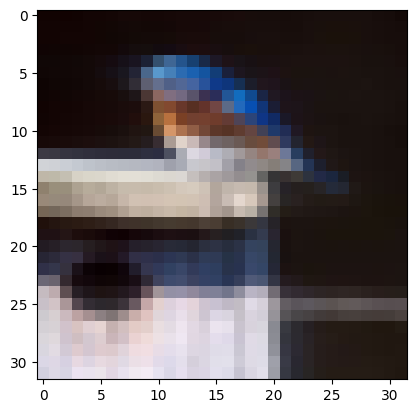

In [87]:
plt.imshow(x_train[13])

In [88]:
y_train[13]

array([2], dtype=uint8)

## 0.2 Проверка дисбаланса классов

In [89]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

Дисбаланса классов нет

# Задание 1 Old school image classifier



## 1.1 Извлечение признаков из изображений

### 1.1.1 Гистограмма яркостей

In [145]:
def get_hist(img: np.ndarray) -> np.ndarray:
    hist, _ = np.histogram(img, bins=100)
    return hist

In [146]:
x_train_hist = np.array([
    get_hist(img) for img in x_train
])

x_test_hist = np.array([
    get_hist(img) for img in x_test
])

### 1.1.2 HOG

In [92]:
from skimage.feature import hog

In [93]:
# Реализация функции приведения изображения в оттенки серого

def rgb_to_gray(image: np.ndarray, coefs: np.ndarray) -> np.ndarray:
    assert image.shape[-1] == len(coefs), f'Число коэффициентов должно совпадать с числом каналов изображения: {len(coefs)} != {image.shape[-1]}'
    return np.clip((image.astype(np.float32) * coefs).sum(axis=-1), a_min=0, a_max=255).astype(np.uint8)

In [94]:
x_train_hog = np.array([
    hog(rgb_to_gray(img, np.array([.299, .587, .114]))) for img in x_train
])

x_test_hog = np.array([
    hog(rgb_to_gray(img, np.array([.299, .587, .114]))) for img in x_test
])

## 1.2 Обучение моделей

In [95]:
from sklearn.base import BaseEstimator

In [96]:
def fit(estimator: BaseEstimator, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, metric: t.Callable, **kwargs) -> BaseEstimator:
    model = estimator(**kwargs)
    model.fit(X_train, y_train)
    print(metric(model.predict(X_test), y_test))
    return model

### 1.2.1 KNN

In [97]:
from sklearn.neighbors import KNeighborsClassifier

In [98]:
estimator = KNeighborsClassifier
params = {
    'n_neighbors': 11,
    'p': 1
}

In [99]:
# признаки с гистограммы яркостей

_ = fit(estimator, x_train_hist, y_train, x_test_hist, y_test, classification_report, **params)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.27      0.33      0.30       840
           1       0.30      0.22      0.26      1351
           2       0.17      0.17      0.17       985
           3       0.14      0.13      0.13      1066
           4       0.24      0.17      0.20      1376
           5       0.17      0.17      0.17       978
           6       0.33      0.19      0.24      1685
           7       0.09      0.17      0.12       552
           8       0.11      0.25      0.15       433
           9       0.22      0.30      0.25       734

    accuracy                           0.20     10000
   macro avg       0.20      0.21      0.20     10000
weighted avg       0.22      0.20      0.21     10000



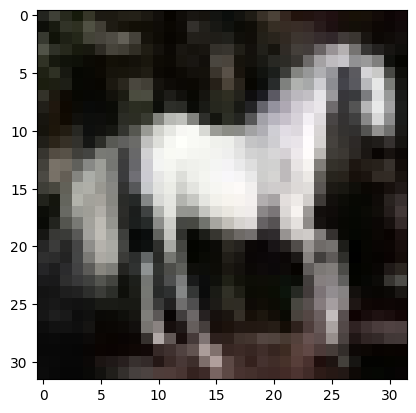

In [100]:
#  предсказание

n = 13
test = x_test_hist[n]
plt.imshow(x_test[n])

In [101]:
label_id = _.predict([test]).item()
id2class[label_id]

'Собака'

In [102]:
# признаки с HOG

_ = fit(estimator, x_train_hog, y_train, x_test_hog, y_test, classification_report, **params)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.63      0.63      0.63       987
           1       0.75      0.67      0.71      1116
           2       0.43      0.52      0.48       827
           3       0.21      0.49      0.30       434
           4       0.58      0.39      0.46      1486
           5       0.40      0.52      0.45       779
           6       0.76      0.50      0.60      1533
           7       0.56      0.70      0.62       793
           8       0.70      0.59      0.65      1186
           9       0.62      0.72      0.67       859

    accuracy                           0.56     10000
   macro avg       0.56      0.57      0.56     10000
weighted avg       0.61      0.56      0.57     10000



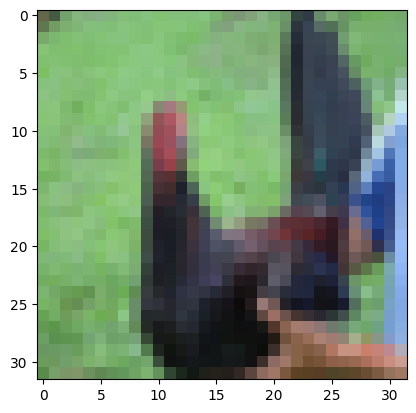

In [103]:
#  предсказание

n = 25
test = x_test_hog[n]
plt.imshow(x_test[n])

In [104]:
label_id = _.predict([test]).item()
id2class[label_id]

'Собака'

### 1.2.2 SVM

In [105]:
from sklearn.svm import SVC

In [106]:
estimator = SVC
params = {
    'C': 0.8,
    'kernel': 'sigmoid',
}

In [107]:
# признаки с гистограммы яркостей

_ = fit(estimator, x_train_hist, y_train, x_test_hist, y_test, classification_report, **params)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.39      0.11      0.17      3738
           1       0.12      0.12      0.12       985
           2       0.12      0.09      0.10      1440
           3       0.01      0.37      0.02        30
           4       0.05      0.16      0.08       341
           5       0.00      0.06      0.01        47
           6       0.09      0.08      0.08      1043
           7       0.03      0.06      0.03       452
           8       0.02      0.11      0.04       207
           9       0.07      0.04      0.05      1717

    accuracy                           0.09     10000
   macro avg       0.09      0.12      0.07     10000
weighted avg       0.20      0.09      0.11     10000



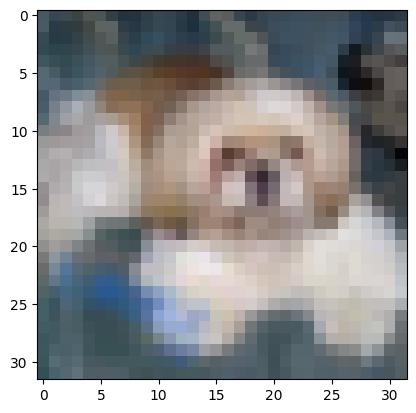

In [108]:
#  предсказание

n = 39
test = x_test_hist[n]
plt.imshow(x_test[n])

In [109]:
label_id = _.predict([test]).item()
id2class[label_id]

'Самолет'

In [110]:
# признаки с HOG

_ = fit(estimator, x_train_hog, y_train, x_test_hog, y_test, classification_report, **params)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.46      0.13      0.20      3502
           1       0.21      0.35      0.26       602
           2       0.19      0.13      0.16      1393
           3       0.09      0.22      0.13       405
           4       0.03      0.28      0.06       119
           5       0.14      0.43      0.21       333
           6       0.22      0.17      0.19      1335
           7       0.11      0.48      0.18       223
           8       0.16      0.44      0.24       372
           9       0.28      0.16      0.21      1716

    accuracy                           0.19     10000
   macro avg       0.19      0.28      0.18     10000
weighted avg       0.29      0.19      0.20     10000



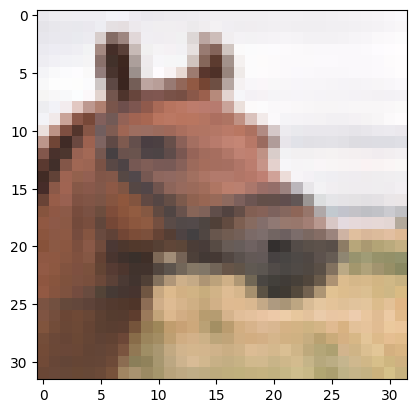

In [111]:
#  предсказание

n = 99
test = x_test_hog[n]
plt.imshow(x_test[n])

In [112]:
label_id = _.predict([test]).item()
id2class[label_id]

'Лягушка'

### 1.2.3 Random Forest

In [113]:
from sklearn.ensemble import RandomForestClassifier

In [114]:
estimator = RandomForestClassifier
params = {
    'n_estimators': 200,
    'max_depth': 15,
}

In [115]:
# признаки с гистограммы яркостей

_ = fit(estimator, x_train_hist, y_train, x_test_hist, y_test, classification_report, **params)

<ipython-input-96-7ff279162869>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       0.43      0.37      0.40      1161
           1       0.31      0.24      0.27      1271
           2       0.16      0.26      0.20       599
           3       0.04      0.21      0.07       207
           4       0.21      0.22      0.21       937
           5       0.13      0.20      0.16       661
           6       0.43      0.27      0.33      1575
           7       0.15      0.19      0.17       806
           8       0.24      0.22      0.23      1093
           9       0.46      0.27      0.34      1690

    accuracy                           0.26     10000
   macro avg       0.26      0.25      0.24     10000
weighted avg       0.31      0.26      0.27     10000



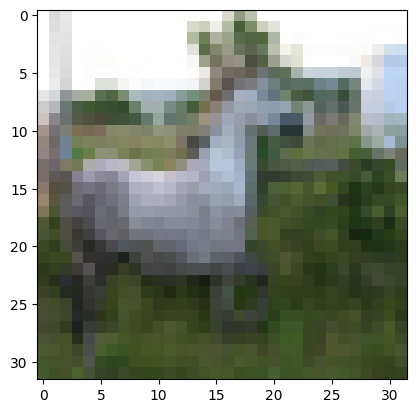

In [116]:
#  предсказание

n = 69
test = x_test_hist[n]
plt.imshow(x_test[n])

In [117]:
label_id = _.predict([test]).item()
id2class[label_id]

'Грузовик'

In [118]:
# признаки с HOG

_ = fit(estimator, x_train_hog, y_train, x_test_hog, y_test, classification_report, **params)

<ipython-input-96-7ff279162869>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


              precision    recall  f1-score   support

           0       0.60      0.62      0.61       980
           1       0.66      0.57      0.61      1149
           2       0.32      0.51      0.39       620
           3       0.23      0.42      0.29       537
           4       0.43      0.42      0.43      1030
           5       0.49      0.40      0.44      1216
           6       0.68      0.47      0.55      1453
           7       0.56      0.60      0.58       925
           8       0.59      0.59      0.59       999
           9       0.62      0.57      0.60      1091

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.51     10000
weighted avg       0.55      0.52      0.53     10000



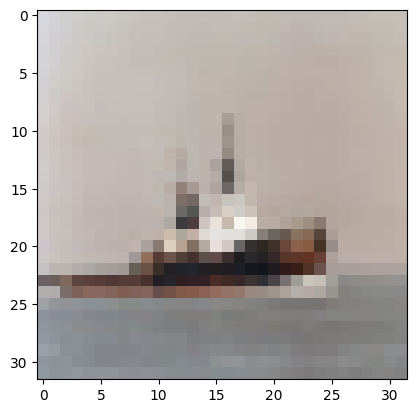

In [119]:
#  предсказание

n = 72
test = x_test_hog[n]
plt.imshow(x_test[n])

In [120]:
label_id = _.predict([test]).item()
id2class[label_id]

'Корабль'

# Задание 2 NN image classifier (без свертки)



In [121]:
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [122]:
N_CLASSES = 10

In [123]:
class NNModel(nn.Module):
    def __init__(self, in_features: int, n_classes: int, lr: float = 1e-7) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

        self.history = []

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def fit(self, train_dl: DataLoader, epoch_number: int = 100) -> None:
        fit_history = []
        for epoch in tqdm(range(epoch_number)):
            loss_values = []
            for x_batch, y_batch in train_dl:
                predict = self.model(x_batch)
                loss = self.criterion(predict, y_batch)
                loss_values.append(loss.item())

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            mean_loss = np.mean(loss_values)
            fit_history.append(mean_loss)
            print(f'\nЭпоха {epoch + 1}, среднее значение функции потерь: {mean_loss}')

        self.history.extend(fit_history)

## 2.1 Обучение на выделенных признаках

### 2.1.1 Гистограмма яркостей

In [164]:
train_ds = TensorDataset(torch.tensor(x_train_hist, dtype=torch.float32), torch.tensor(y_train.squeeze()))
train_dl = DataLoader(train_ds, batch_size=64)

In [165]:
model = NNModel(len(x_train_hist[0]), N_CLASSES)
model.fit(train_dl)

  1%|          | 1/100 [00:02<04:02,  2.45s/it]


Эпоха 1, среднее значение функции потерь: 16.558071307209143


  2%|▏         | 2/100 [00:06<05:09,  3.16s/it]


Эпоха 2, среднее значение функции потерь: 16.09985010459295


  3%|▎         | 3/100 [00:08<04:35,  2.84s/it]


Эпоха 3, среднее значение функции потерь: 15.669838591914653


  4%|▍         | 4/100 [00:12<05:04,  3.17s/it]


Эпоха 4, среднее значение функции потерь: 15.264423552071651


  5%|▌         | 5/100 [00:14<04:32,  2.87s/it]


Эпоха 5, среднее значение функции потерь: 14.879945756224416


  6%|▌         | 6/100 [00:17<04:43,  3.02s/it]


Эпоха 6, среднее значение функции потерь: 14.513271492765382


  7%|▋         | 7/100 [00:22<05:18,  3.43s/it]


Эпоха 7, среднее значение функции потерь: 14.162156429437115


  8%|▊         | 8/100 [00:25<05:01,  3.27s/it]


Эпоха 8, среднее значение функции потерь: 13.824910766328387


  9%|▉         | 9/100 [00:27<04:37,  3.05s/it]


Эпоха 9, среднее значение функции потерь: 13.500489092239029


 10%|█         | 10/100 [00:29<04:09,  2.77s/it]


Эпоха 10, среднее значение функции потерь: 13.18830099252179


 11%|█         | 11/100 [00:32<04:12,  2.84s/it]


Эпоха 11, среднее значение функции потерь: 12.888065074715772


 12%|█▏        | 12/100 [00:36<04:31,  3.08s/it]


Эпоха 12, среднее значение функции потерь: 12.599879316051902


 13%|█▎        | 13/100 [00:37<03:44,  2.58s/it]


Эпоха 13, среднее значение функции потерь: 12.323898270306989


 14%|█▍        | 14/100 [00:39<03:13,  2.25s/it]


Эпоха 14, среднее значение функции потерь: 12.060383641811283


 15%|█▌        | 15/100 [00:40<02:50,  2.01s/it]


Эпоха 15, среднее значение функции потерь: 11.809618730374309


 16%|█▌        | 16/100 [00:42<02:48,  2.01s/it]


Эпоха 16, среднее значение функции потерь: 11.571697194862853


 17%|█▋        | 17/100 [00:45<02:59,  2.16s/it]


Эпоха 17, среднее значение функции потерь: 11.34649902231553


 18%|█▊        | 18/100 [00:49<03:45,  2.75s/it]


Эпоха 18, среднее значение функции потерь: 11.133573994307262


 19%|█▉        | 19/100 [00:54<04:48,  3.56s/it]


Эпоха 19, среднее значение функции потерь: 10.932357161246298


 20%|██        | 20/100 [00:58<04:52,  3.66s/it]


Эпоха 20, среднее значение функции потерь: 10.742143941352435


 21%|██        | 21/100 [01:00<04:04,  3.09s/it]


Эпоха 21, среднее значение функции потерь: 10.562154844288935


 22%|██▏       | 22/100 [01:02<03:42,  2.86s/it]


Эпоха 22, среднее значение функции потерь: 10.391576125493744


 23%|██▎       | 23/100 [01:04<03:21,  2.62s/it]


Эпоха 23, среднее значение функции потерь: 10.229682905289827


 24%|██▍       | 24/100 [01:07<03:13,  2.55s/it]


Эпоха 24, среднее значение функции потерь: 10.075801439602357


 25%|██▌       | 25/100 [01:08<02:47,  2.23s/it]


Эпоха 25, среднее значение функции потерь: 9.929384591329432


 26%|██▌       | 26/100 [01:10<02:26,  1.98s/it]


Эпоха 26, среднее значение функции потерь: 9.789862005302059


 27%|██▋       | 27/100 [01:11<02:12,  1.82s/it]


Эпоха 27, среднее значение функции потерь: 9.656709124670003


 28%|██▊       | 28/100 [01:13<02:01,  1.69s/it]


Эпоха 28, среднее значение функции потерь: 9.529430923559477


 29%|██▉       | 29/100 [01:14<01:55,  1.63s/it]


Эпоха 29, среднее значение функции потерь: 9.407599855261996


 30%|███       | 30/100 [01:15<01:49,  1.56s/it]


Эпоха 30, среднее значение функции потерь: 9.290806897156074


 31%|███       | 31/100 [01:17<01:44,  1.51s/it]


Эпоха 31, среднее значение функции потерь: 9.178653109713894


 32%|███▏      | 32/100 [01:19<01:51,  1.64s/it]


Эпоха 32, среднее значение функции потерь: 9.070783589502124


 33%|███▎      | 33/100 [01:21<01:59,  1.78s/it]


Эпоха 33, среднее значение функции потерь: 8.966876320216967


 34%|███▍      | 34/100 [01:22<01:53,  1.72s/it]


Эпоха 34, среднее значение функции потерь: 8.866678049497287


 35%|███▌      | 35/100 [01:24<01:45,  1.63s/it]


Эпоха 35, среднее значение функции потерь: 8.769937803678195


 36%|███▌      | 36/100 [01:25<01:40,  1.57s/it]


Эпоха 36, среднее значение функции потерь: 8.676486222030562


 37%|███▋      | 37/100 [01:27<01:35,  1.52s/it]


Эпоха 37, среднее значение функции потерь: 8.586178669844138


 38%|███▊      | 38/100 [01:28<01:32,  1.48s/it]


Эпоха 38, среднее значение функции потерь: 8.49890781485516


 39%|███▉      | 39/100 [01:30<01:29,  1.47s/it]


Эпоха 39, среднее значение функции потерь: 8.414604254695766


 40%|████      | 40/100 [01:31<01:28,  1.47s/it]


Эпоха 40, среднее значение функции потерь: 8.33318782523465


 41%|████      | 41/100 [01:33<01:35,  1.62s/it]


Эпоха 41, среднее значение функции потерь: 8.254574240930856


 42%|████▏     | 42/100 [01:35<01:42,  1.77s/it]


Эпоха 42, среднее значение функции потерь: 8.17868571391191


 43%|████▎     | 43/100 [01:37<01:35,  1.68s/it]


Эпоха 43, среднее значение функции потерь: 8.105443702634338


 44%|████▍     | 44/100 [01:38<01:29,  1.59s/it]


Эпоха 44, среднее значение функции потерь: 8.034743979763801


 45%|████▌     | 45/100 [01:39<01:24,  1.54s/it]


Эпоха 45, среднее значение функции потерь: 7.9664397111634155


 46%|████▌     | 46/100 [01:41<01:21,  1.52s/it]


Эпоха 46, среднее значение функции потерь: 7.900383546834102


 47%|████▋     | 47/100 [01:42<01:19,  1.50s/it]


Эпоха 47, среднее значение функции потерь: 7.836419089066098


 48%|████▊     | 48/100 [01:44<01:16,  1.48s/it]


Эпоха 48, среднее значение функции потерь: 7.774366103779629


 49%|████▉     | 49/100 [01:45<01:14,  1.47s/it]


Эпоха 49, среднее значение функции потерь: 7.714045198982024


 50%|█████     | 50/100 [01:48<01:40,  2.01s/it]


Эпоха 50, среднее значение функции потерь: 7.655287357242516


 51%|█████     | 51/100 [01:50<01:32,  1.90s/it]


Эпоха 51, среднее значение функции потерь: 7.597969309448281


 52%|█████▏    | 52/100 [01:51<01:24,  1.76s/it]


Эпоха 52, среднее значение функции потерь: 7.541904378120247


 53%|█████▎    | 53/100 [01:53<01:17,  1.66s/it]


Эпоха 53, среднее значение функции потерь: 7.486991621954057


 54%|█████▍    | 54/100 [01:54<01:12,  1.58s/it]


Эпоха 54, среднее значение функции потерь: 7.433146534063627


 55%|█████▌    | 55/100 [01:56<01:09,  1.55s/it]


Эпоха 55, среднее значение функции потерь: 7.380281253239078


 56%|█████▌    | 56/100 [01:57<01:07,  1.52s/it]


Эпоха 56, среднее значение функции потерь: 7.328337884620023


 57%|█████▋    | 57/100 [01:59<01:05,  1.52s/it]


Эпоха 57, среднее значение функции потерь: 7.277297612041464


 58%|█████▊    | 58/100 [02:01<01:08,  1.63s/it]


Эпоха 58, среднее значение функции потерь: 7.22709746068091


 59%|█████▉    | 59/100 [02:03<01:13,  1.79s/it]


Эпоха 59, среднее значение функции потерь: 7.177702054953026


 60%|██████    | 60/100 [02:04<01:09,  1.75s/it]


Эпоха 60, среднее значение функции потерь: 7.129094535432508


 61%|██████    | 61/100 [02:06<01:04,  1.65s/it]


Эпоха 61, среднее значение функции потерь: 7.08123770333312


 62%|██████▏   | 62/100 [02:07<00:59,  1.58s/it]


Эпоха 62, среднее значение функции потерь: 7.034094955610192


 63%|██████▎   | 63/100 [02:09<00:56,  1.52s/it]


Эпоха 63, среднее значение функции потерь: 6.987663953810396


 64%|██████▍   | 64/100 [02:10<00:53,  1.50s/it]


Эпоха 64, среднее значение функции потерь: 6.941925672618934


 65%|██████▌   | 65/100 [02:12<00:51,  1.48s/it]


Эпоха 65, среднее значение функции потерь: 6.896864745318127


 66%|██████▌   | 66/100 [02:13<00:49,  1.46s/it]


Эпоха 66, среднее значение функции потерь: 6.852447635987225


 67%|██████▋   | 67/100 [02:15<00:51,  1.55s/it]


Эпоха 67, среднее значение функции потерь: 6.808669491497147


 68%|██████▊   | 68/100 [02:17<00:55,  1.73s/it]


Эпоха 68, среднее значение функции потерь: 6.765526287391058


 69%|██████▉   | 69/100 [02:18<00:51,  1.66s/it]


Эпоха 69, среднее значение функции потерь: 6.723009655847574


 70%|███████   | 70/100 [02:20<00:47,  1.58s/it]


Эпоха 70, среднее значение функции потерь: 6.681136880689265


 71%|███████   | 71/100 [02:21<00:44,  1.54s/it]


Эпоха 71, среднее значение функции потерь: 6.6398835779760805


 72%|███████▏  | 72/100 [02:23<00:42,  1.50s/it]


Эпоха 72, среднее значение функции потерь: 6.599226111951082


 73%|███████▎  | 73/100 [02:24<00:39,  1.47s/it]


Эпоха 73, среднее значение функции потерь: 6.5591492244349725


 74%|███████▍  | 74/100 [02:25<00:37,  1.45s/it]


Эпоха 74, среднее значение функции потерь: 6.519650512339209


 75%|███████▌  | 75/100 [02:27<00:36,  1.44s/it]


Эпоха 75, среднее значение функции потерь: 6.480730042738073


 76%|███████▌  | 76/100 [02:29<00:38,  1.61s/it]


Эпоха 76, среднее значение функции потерь: 6.4423763050752525


 77%|███████▋  | 77/100 [02:31<00:40,  1.76s/it]


Эпоха 77, среднее значение функции потерь: 6.404584223657008


 78%|███████▊  | 78/100 [02:32<00:36,  1.68s/it]


Эпоха 78, среднее значение функции потерь: 6.3673657944135345


 79%|███████▉  | 79/100 [02:34<00:33,  1.60s/it]


Эпоха 79, среднее значение функции потерь: 6.330715227614888


 80%|████████  | 80/100 [02:35<00:31,  1.57s/it]


Эпоха 80, среднее значение функции потерь: 6.294627207929216


 81%|████████  | 81/100 [02:37<00:28,  1.52s/it]


Эпоха 81, среднее значение функции потерь: 6.259096621857275


 82%|████████▏ | 82/100 [02:38<00:26,  1.49s/it]


Эпоха 82, среднее значение функции потерь: 6.224106920649634


 83%|████████▎ | 83/100 [02:40<00:24,  1.46s/it]


Эпоха 83, среднее значение функции потерь: 6.189660622640644


 84%|████████▍ | 84/100 [02:41<00:23,  1.46s/it]


Эпоха 84, среднее значение функции потерь: 6.15575903608366


 85%|████████▌ | 85/100 [02:43<00:24,  1.63s/it]


Эпоха 85, среднее значение функции потерь: 6.122395865447686


 86%|████████▌ | 86/100 [02:47<00:31,  2.22s/it]


Эпоха 86, среднее значение функции потерь: 6.0895728927744015


 87%|████████▋ | 87/100 [02:48<00:25,  1.98s/it]


Эпоха 87, среднее значение функции потерь: 6.05729749135654


 88%|████████▊ | 88/100 [02:50<00:21,  1.82s/it]


Эпоха 88, среднее значение функции потерь: 6.025575700318417


 89%|████████▉ | 89/100 [02:51<00:18,  1.70s/it]


Эпоха 89, среднее значение функции потерь: 5.994409423350068


 90%|█████████ | 90/100 [02:52<00:16,  1.62s/it]


Эпоха 90, среднее значение функции потерь: 5.96379430092814


 91%|█████████ | 91/100 [02:54<00:14,  1.57s/it]


Эпоха 91, среднее значение функции потерь: 5.933716106597725


 92%|█████████▏| 92/100 [02:55<00:12,  1.52s/it]


Эпоха 92, среднее значение функции потерь: 5.904192625104314


 93%|█████████▎| 93/100 [02:57<00:11,  1.64s/it]


Эпоха 93, среднее значение функции потерь: 5.875232903853707


 94%|█████████▍| 94/100 [02:59<00:10,  1.77s/it]


Эпоха 94, среднее значение функции потерь: 5.846847257345838


 95%|█████████▌| 95/100 [03:01<00:08,  1.74s/it]


Эпоха 95, среднее значение функции потерь: 5.819039391129828


 96%|█████████▌| 96/100 [03:02<00:06,  1.66s/it]


Эпоха 96, среднее значение функции потерь: 5.791792451268267


 97%|█████████▋| 97/100 [03:04<00:04,  1.59s/it]


Эпоха 97, среднее значение функции потерь: 5.76512174502663


 98%|█████████▊| 98/100 [03:05<00:03,  1.54s/it]


Эпоха 98, среднее значение функции потерь: 5.739018321951942


 99%|█████████▉| 99/100 [03:07<00:01,  1.52s/it]


Эпоха 99, среднее значение функции потерь: 5.713464469251121


100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


Эпоха 100, среднее значение функции потерь: 5.68846677971618


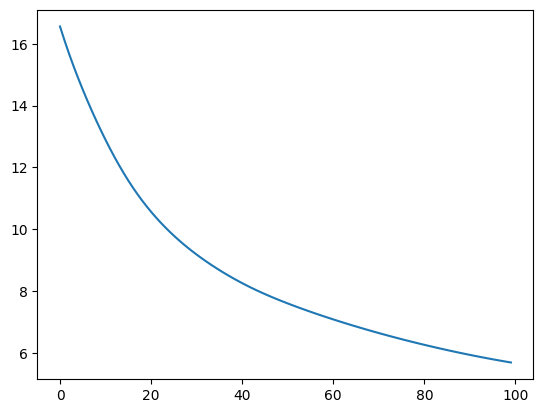

In [166]:
plt.plot(model.history)

In [167]:
y_pred = model(torch.tensor(x_test_hist, dtype=torch.float32)).detach().softmax(1).argmax(1)
print(classification_report(y_pred.numpy(), y_test.squeeze()))

              precision    recall  f1-score   support

           0       0.15      0.15      0.15      1031
           1       0.10      0.11      0.10       940
           2       0.12      0.13      0.12       973
           3       0.11      0.11      0.11       958
           4       0.15      0.15      0.15      1014
           5       0.12      0.11      0.11      1082
           6       0.09      0.09      0.09      1045
           7       0.08      0.09      0.08       961
           8       0.11      0.11      0.11       988
           9       0.15      0.15      0.15      1008

    accuracy                           0.12     10000
   macro avg       0.12      0.12      0.12     10000
weighted avg       0.12      0.12      0.12     10000



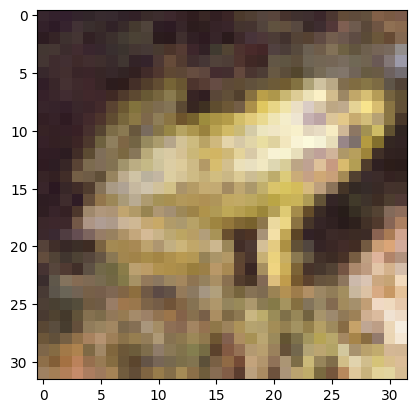

In [168]:
#  предсказание

n = 19
test = x_test_hist[n]
plt.imshow(x_test[n])

In [185]:
label_id = model(torch.tensor(test, dtype=torch.float32).unsqueeze(0)).detach().softmax(1).argmax(1).item()
id2class[label_id]

'Лягушка'

### 2.1.2 HOG

In [170]:
train_ds = TensorDataset(torch.tensor(x_train_hog, dtype=torch.float32), torch.tensor(y_train.squeeze()))
train_dl = DataLoader(train_ds, batch_size=64)

In [171]:
model = NNModel(len(x_train_hog[0]), N_CLASSES)
model.fit(train_dl)

  1%|          | 1/100 [00:01<02:59,  1.81s/it]


Эпоха 1, среднее значение функции потерь: 2.303013203698961


  2%|▏         | 2/100 [00:04<03:34,  2.19s/it]


Эпоха 2, среднее значение функции потерь: 2.3027909359968532


  3%|▎         | 3/100 [00:06<03:27,  2.14s/it]


Эпоха 3, среднее значение функции потерь: 2.302568929579557


  4%|▍         | 4/100 [00:07<03:06,  1.95s/it]


Эпоха 4, среднее значение функции потерь: 2.3023473304860733


  5%|▌         | 5/100 [00:09<02:55,  1.85s/it]


Эпоха 5, среднее значение функции потерь: 2.302126170119361


  6%|▌         | 6/100 [00:11<02:47,  1.79s/it]


Эпоха 6, среднее значение функции потерь: 2.3019053439045196


  7%|▋         | 7/100 [00:12<02:40,  1.73s/it]


Эпоха 7, среднее значение функции потерь: 2.3016845521414675


  8%|▊         | 8/100 [00:14<02:38,  1.72s/it]


Эпоха 8, среднее значение функции потерь: 2.301464038431797


  9%|▉         | 9/100 [00:16<02:44,  1.81s/it]


Эпоха 9, среднее значение функции потерь: 2.301243807653637


 10%|█         | 10/100 [00:19<03:06,  2.07s/it]


Эпоха 10, среднее значение функции потерь: 2.301023631754434


 11%|█         | 11/100 [00:21<03:01,  2.03s/it]


Эпоха 11, среднее значение функции потерь: 2.300803603723531


 12%|█▏        | 12/100 [00:22<02:51,  1.95s/it]


Эпоха 12, среднее значение функции потерь: 2.3005837558785363


 13%|█▎        | 13/100 [00:24<02:40,  1.85s/it]


Эпоха 13, среднее значение функции потерь: 2.3003638882161406


 14%|█▍        | 14/100 [00:26<02:33,  1.78s/it]


Эпоха 14, среднее значение функции потерь: 2.300144172995292


 15%|█▌        | 15/100 [00:27<02:28,  1.75s/it]


Эпоха 15, среднее значение функции потерь: 2.2999244111273294


 16%|█▌        | 16/100 [00:29<02:23,  1.71s/it]


Эпоха 16, среднее значение функции потерь: 2.299704588892515


 17%|█▋        | 17/100 [00:31<02:35,  1.88s/it]


Эпоха 17, среднее значение функции потерь: 2.299484765743051


 18%|█▊        | 18/100 [00:34<02:51,  2.09s/it]


Эпоха 18, среднее значение функции потерь: 2.2992648480798277


 19%|█▉        | 19/100 [00:36<02:38,  1.96s/it]


Эпоха 19, среднее значение функции потерь: 2.2990448310247165


 20%|██        | 20/100 [00:37<02:29,  1.87s/it]


Эпоха 20, среднее значение функции потерь: 2.2988248782999374


 21%|██        | 21/100 [00:39<02:21,  1.80s/it]


Эпоха 21, среднее значение функции потерь: 2.298604871001085


 22%|██▏       | 22/100 [00:40<02:15,  1.74s/it]


Эпоха 22, среднее значение функции потерь: 2.2983847423587616


 23%|██▎       | 23/100 [00:42<02:11,  1.71s/it]


Эпоха 23, среднее значение функции потерь: 2.298164623472697


 24%|██▍       | 24/100 [00:44<02:08,  1.68s/it]


Эпоха 24, среднее значение функции потерь: 2.2979443759259666


 25%|██▌       | 25/100 [00:46<02:23,  1.91s/it]


Эпоха 25, среднее значение функции потерь: 2.297723868923724


 26%|██▌       | 26/100 [00:48<02:24,  1.95s/it]


Эпоха 26, среднее значение функции потерь: 2.2975031079538644


 27%|██▋       | 27/100 [00:50<02:15,  1.86s/it]


Эпоха 27, среднее значение функции потерь: 2.2972823466791215


 28%|██▊       | 28/100 [00:51<02:09,  1.79s/it]


Эпоха 28, среднее значение функции потерь: 2.2970614021696396


 29%|██▉       | 29/100 [00:53<02:04,  1.75s/it]


Эпоха 29, среднее значение функции потерь: 2.2968401402768577


 30%|███       | 30/100 [00:55<02:00,  1.71s/it]


Эпоха 30, среднее значение функции потерь: 2.296618583562124


 31%|███       | 31/100 [00:56<01:57,  1.71s/it]


Эпоха 31, среднее значение функции потерь: 2.296396705195727


 32%|███▏      | 32/100 [00:59<02:04,  1.83s/it]


Эпоха 32, среднее значение функции потерь: 2.2961745588370905


 33%|███▎      | 33/100 [01:01<02:14,  2.01s/it]


Эпоха 33, среднее значение функции потерь: 2.2959520905219075


 34%|███▍      | 34/100 [01:03<02:10,  1.98s/it]


Эпоха 34, среднее значение функции потерь: 2.295729343238694


 35%|███▌      | 35/100 [01:05<02:04,  1.91s/it]


Эпоха 35, среднее значение функции потерь: 2.2955064669899317


 36%|███▌      | 36/100 [01:06<01:57,  1.83s/it]


Эпоха 36, среднее значение функции потерь: 2.295283311468256


 37%|███▋      | 37/100 [01:08<01:52,  1.78s/it]


Эпоха 37, среднее значение функции потерь: 2.2950599251500785


 38%|███▊      | 38/100 [01:10<01:47,  1.74s/it]


Эпоха 38, среднее значение функции потерь: 2.2948362781568563


 39%|███▉      | 39/100 [01:11<01:44,  1.71s/it]


Эпоха 39, среднее значение функции потерь: 2.294612553113562


 40%|████      | 40/100 [01:13<01:50,  1.84s/it]


Эпоха 40, среднее значение функции потерь: 2.294388738434638


 41%|████      | 41/100 [01:16<02:01,  2.05s/it]


Эпоха 41, среднее значение функции потерь: 2.2941646216165683


 42%|████▏     | 42/100 [01:18<01:52,  1.94s/it]


Эпоха 42, среднее значение функции потерь: 2.293940149914578


 43%|████▎     | 43/100 [01:19<01:47,  1.88s/it]


Эпоха 43, среднее значение функции потерь: 2.2937154285133343


 44%|████▍     | 44/100 [01:21<01:43,  1.85s/it]


Эпоха 44, среднее значение функции потерь: 2.293490464425148


 45%|████▌     | 45/100 [01:24<02:00,  2.18s/it]


Эпоха 45, среднее значение функции потерь: 2.2932651253307568


 46%|████▌     | 46/100 [01:27<02:04,  2.31s/it]


Эпоха 46, среднее значение функции потерь: 2.293039406352031


 47%|████▋     | 47/100 [01:29<02:08,  2.42s/it]


Эпоха 47, среднее значение функции потерь: 2.2928135224315516


 48%|████▊     | 48/100 [01:32<02:05,  2.42s/it]


Эпоха 48, среднее значение функции потерь: 2.2925875022283297


 49%|████▉     | 49/100 [01:33<01:51,  2.19s/it]


Эпоха 49, среднее значение функции потерь: 2.2923611561050805


 50%|█████     | 50/100 [01:35<01:42,  2.05s/it]


Эпоха 50, среднее значение функции потерь: 2.2921344212558874


 51%|█████     | 51/100 [01:37<01:34,  1.93s/it]


Эпоха 51, среднее значение функции потерь: 2.291907637015633


 52%|█████▏    | 52/100 [01:38<01:28,  1.85s/it]


Эпоха 52, среднее значение функции потерь: 2.291680582648958


 53%|█████▎    | 53/100 [01:40<01:23,  1.78s/it]


Эпоха 53, среднее значение функции потерь: 2.2914532273626693


 54%|█████▍    | 54/100 [01:42<01:23,  1.81s/it]


Эпоха 54, среднее значение функции потерь: 2.2912256482921904


 55%|█████▌    | 55/100 [01:44<01:29,  2.00s/it]


Эпоха 55, среднее значение функции потерь: 2.290997771960695


 56%|█████▌    | 56/100 [01:46<01:25,  1.94s/it]


Эпоха 56, среднее значение функции потерь: 2.2907694773295955


 57%|█████▋    | 57/100 [01:48<01:19,  1.86s/it]


Эпоха 57, среднее значение функции потерь: 2.2905410003784064


 58%|█████▊    | 58/100 [01:50<01:16,  1.82s/it]


Эпоха 58, среднее значение функции потерь: 2.2903121782995552


 59%|█████▉    | 59/100 [01:51<01:12,  1.76s/it]


Эпоха 59, среднее значение функции потерь: 2.2900830586548047


 60%|██████    | 60/100 [01:53<01:09,  1.73s/it]


Эпоха 60, среднее значение функции потерь: 2.289853531076475


 61%|██████    | 61/100 [01:55<01:07,  1.73s/it]


Эпоха 61, среднее значение функции потерь: 2.2896235190389103


 62%|██████▏   | 62/100 [01:57<01:12,  1.91s/it]


Эпоха 62, среднее значение функции потерь: 2.2893930941896365


 63%|██████▎   | 63/100 [01:59<01:14,  2.01s/it]


Эпоха 63, среднее значение функции потерь: 2.28916234281057


 64%|██████▍   | 64/100 [02:01<01:08,  1.91s/it]


Эпоха 64, среднее значение функции потерь: 2.288931206059273


 65%|██████▌   | 65/100 [02:03<01:05,  1.87s/it]


Эпоха 65, среднее значение функции потерь: 2.288699510152383


 66%|██████▌   | 66/100 [02:04<01:01,  1.81s/it]


Эпоха 66, среднее значение функции потерь: 2.288467401738667


 67%|██████▋   | 67/100 [02:06<00:59,  1.79s/it]


Эпоха 67, среднее значение функции потерь: 2.288234943928926


 68%|██████▊   | 68/100 [02:08<00:56,  1.75s/it]


Эпоха 68, среднее значение функции потерь: 2.2880021461745357


 69%|██████▉   | 69/100 [02:10<00:57,  1.84s/it]


Эпоха 69, среднее значение функции потерь: 2.2877689987192373


 70%|███████   | 70/100 [02:12<01:01,  2.03s/it]


Эпоха 70, среднее значение функции потерь: 2.287535568637311


 71%|███████   | 71/100 [02:14<00:57,  1.98s/it]


Эпоха 71, среднее значение функции потерь: 2.2873015614116894


 72%|███████▏  | 72/100 [02:16<00:52,  1.88s/it]


Эпоха 72, среднее значение функции потерь: 2.2870670392385226


 73%|███████▎  | 73/100 [02:17<00:49,  1.82s/it]


Эпоха 73, среднее значение функции потерь: 2.286832136876138


 74%|███████▍  | 74/100 [02:19<00:46,  1.79s/it]


Эпоха 74, среднее значение функции потерь: 2.286596812555552


 75%|███████▌  | 75/100 [02:21<00:44,  1.77s/it]


Эпоха 75, среднее значение функции потерь: 2.286361124509436


 76%|███████▌  | 76/100 [02:23<00:41,  1.73s/it]


Эпоха 76, среднее значение функции потерь: 2.2861248151115747


 77%|███████▋  | 77/100 [02:25<00:43,  1.88s/it]


Эпоха 77, среднее значение функции потерь: 2.2858878005191188


 78%|███████▊  | 78/100 [02:27<00:45,  2.07s/it]


Эпоха 78, среднее значение функции потерь: 2.2856501651846846


 79%|███████▉  | 79/100 [02:29<00:40,  1.94s/it]


Эпоха 79, среднее значение функции потерь: 2.285412035024989


 80%|████████  | 80/100 [02:31<00:37,  1.85s/it]


Эпоха 80, среднее значение функции потерь: 2.285173301806535


 81%|████████  | 81/100 [02:32<00:34,  1.80s/it]


Эпоха 81, среднее значение функции потерь: 2.2849340630919124


 82%|████████▏ | 82/100 [02:34<00:31,  1.76s/it]


Эпоха 82, среднее значение функции потерь: 2.2846943201006527


 83%|████████▎ | 83/100 [02:36<00:29,  1.73s/it]


Эпоха 83, среднее значение функции потерь: 2.2844540255758767


 84%|████████▍ | 84/100 [02:37<00:27,  1.72s/it]


Эпоха 84, среднее значение функции потерь: 2.284213179212702


 85%|████████▌ | 85/100 [02:40<00:29,  1.95s/it]


Эпоха 85, среднее значение функции потерь: 2.283971716985678


 86%|████████▌ | 86/100 [02:42<00:29,  2.08s/it]


Эпоха 86, среднее значение функции потерь: 2.283729871520606


 87%|████████▋ | 87/100 [02:44<00:25,  1.96s/it]


Эпоха 87, среднее значение функции потерь: 2.2834874071428537


 88%|████████▊ | 88/100 [02:45<00:22,  1.86s/it]


Эпоха 88, среднее значение функции потерь: 2.2832444006829617


 89%|████████▉ | 89/100 [02:47<00:19,  1.80s/it]


Эпоха 89, среднее значение функции потерь: 2.2830007234802636


 90%|█████████ | 90/100 [02:49<00:17,  1.77s/it]


Эпоха 90, среднее значение функции потерь: 2.2827564999270624


 91%|█████████ | 91/100 [02:50<00:15,  1.74s/it]


Эпоха 91, среднее значение функции потерь: 2.2825118288054798


 92%|█████████▏| 92/100 [02:52<00:14,  1.82s/it]


Эпоха 92, среднее значение функции потерь: 2.2822667619456416


 93%|█████████▎| 93/100 [02:55<00:14,  2.02s/it]


Эпоха 93, среднее значение функции потерь: 2.28202147099673


 94%|█████████▍| 94/100 [02:57<00:12,  2.04s/it]


Эпоха 94, среднее значение функции потерь: 2.281775794370705


 95%|█████████▌| 95/100 [02:59<00:09,  1.94s/it]


Эпоха 95, среднее значение функции потерь: 2.2815297439580076


 96%|█████████▌| 96/100 [03:00<00:07,  1.86s/it]


Эпоха 96, среднее значение функции потерь: 2.281283270367576


 97%|█████████▋| 97/100 [03:02<00:05,  1.79s/it]


Эпоха 97, среднее значение функции потерь: 2.2810362165846176


 98%|█████████▊| 98/100 [03:04<00:03,  1.77s/it]


Эпоха 98, среднее значение функции потерь: 2.280788748770419


 99%|█████████▉| 99/100 [03:05<00:01,  1.75s/it]


Эпоха 99, среднее значение функции потерь: 2.2805410397936927


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


Эпоха 100, среднее значение функции потерь: 2.280292931420114


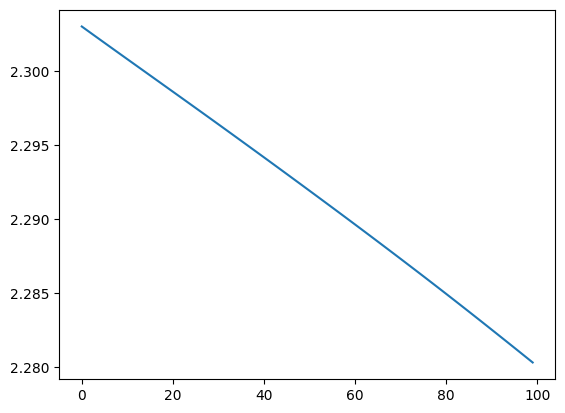

In [172]:
plt.plot(model.history)

In [173]:
y_pred = model(torch.tensor(x_test_hog, dtype=torch.float32)).detach().softmax(1).argmax(1)
print(classification_report(y_pred.numpy(), y_test.squeeze()))

              precision    recall  f1-score   support

           0       0.64      0.27      0.38      2428
           1       0.28      0.41      0.33       676
           2       0.00      0.00      0.00         0
           3       0.02      0.22      0.03        72
           4       0.24      0.17      0.20      1448
           5       0.71      0.21      0.32      3408
           6       0.29      0.38      0.33       756
           7       0.19      0.20      0.19       963
           8       0.00      0.00      0.00         0
           9       0.12      0.49      0.20       249

    accuracy                           0.25     10000
   macro avg       0.25      0.23      0.20     10000
weighted avg       0.49      0.25      0.30     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


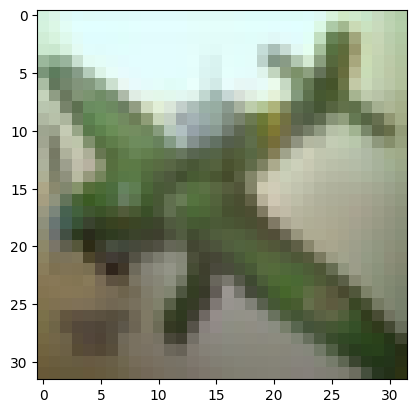

In [174]:
#  предсказание

n = 27
test = x_train_hog[n]
plt.imshow(x_test[n])

In [184]:
label_id = model(torch.tensor(test, dtype=torch.float32).unsqueeze(0)).detach().softmax(1).argmax(1).item()
id2class[label_id]

'Лягушка'

## 2.2 Обучение на исходных изображениях

In [176]:
x_train_flatten = x_train.reshape(len(x_train), -1)
x_test_flatten = x_test.reshape(len(x_test), -1)

In [177]:
train_ds = TensorDataset(torch.tensor(x_train_flatten / 255, dtype=torch.float32), torch.tensor(y_train.squeeze()))
train_dl = DataLoader(train_ds, batch_size=64)

In [178]:
model = NNModel(len(x_train_flatten[0]), N_CLASSES)
model.fit(train_dl)

  1%|          | 1/100 [00:06<10:40,  6.47s/it]


Эпоха 1, среднее значение функции потерь: 2.317153521206068


  2%|▏         | 2/100 [00:11<09:11,  5.62s/it]


Эпоха 2, среднее значение функции потерь: 2.30548920228963


  3%|▎         | 3/100 [00:17<09:33,  5.91s/it]


Эпоха 3, среднее значение функции потерь: 2.2970653894307365


  4%|▍         | 4/100 [00:22<08:51,  5.54s/it]


Эпоха 4, среднее значение функции потерь: 2.290719706384117


  5%|▌         | 5/100 [00:28<08:41,  5.49s/it]


Эпоха 5, среднее значение функции потерь: 2.2856346243787606


  6%|▌         | 6/100 [00:34<08:53,  5.68s/it]


Эпоха 6, среднее значение функции потерь: 2.281321583806401


  7%|▋         | 7/100 [00:39<08:26,  5.45s/it]


Эпоха 7, среднее значение функции потерь: 2.2774236610783336


  8%|▊         | 8/100 [00:45<08:44,  5.71s/it]


Эпоха 8, среднее значение функции потерь: 2.27375598484293


  9%|▉         | 9/100 [00:50<08:18,  5.48s/it]


Эпоха 9, среднее значение функции потерь: 2.2703193429181034


 10%|█         | 10/100 [00:55<08:04,  5.38s/it]


Эпоха 10, среднее значение функции потерь: 2.266993812892748


 11%|█         | 11/100 [01:01<08:19,  5.61s/it]


Эпоха 11, среднее значение функции потерь: 2.2636316444562827


 12%|█▏        | 12/100 [01:06<07:59,  5.45s/it]


Эпоха 12, среднее значение функции потерь: 2.260136055824397


 13%|█▎        | 13/100 [01:12<08:11,  5.65s/it]


Эпоха 13, среднее значение функции потерь: 2.2567378919752663


 14%|█▍        | 14/100 [01:18<07:57,  5.55s/it]


Эпоха 14, среднее значение функции потерь: 2.2535519276738474


 15%|█▌        | 15/100 [01:23<07:38,  5.40s/it]


Эпоха 15, среднее значение функции потерь: 2.2504879663057644


 16%|█▌        | 16/100 [01:29<07:58,  5.70s/it]


Эпоха 16, среднее значение функции потерь: 2.2474853529039858


 17%|█▋        | 17/100 [01:34<07:38,  5.52s/it]


Эпоха 17, среднее значение функции потерь: 2.244513054942841


 18%|█▊        | 18/100 [01:40<07:39,  5.61s/it]


Эпоха 18, среднее значение функции потерь: 2.2415277781084066


 19%|█▉        | 19/100 [01:46<07:41,  5.69s/it]


Эпоха 19, среднее значение функции потерь: 2.238543372020087


 20%|██        | 20/100 [01:51<07:22,  5.53s/it]


Эпоха 20, среднее значение функции потерь: 2.2356354681122332


 21%|██        | 21/100 [01:59<08:13,  6.25s/it]


Эпоха 21, среднее значение функции потерь: 2.2327844349624555


 22%|██▏       | 22/100 [02:04<07:42,  5.93s/it]


Эпоха 22, среднее значение функции потерь: 2.2299711103634454


 23%|██▎       | 23/100 [02:10<07:23,  5.76s/it]


Эпоха 23, среднее значение функции потерь: 2.2271857465929386


 24%|██▍       | 24/100 [02:16<07:31,  5.94s/it]


Эпоха 24, среднее значение функции потерь: 2.224420349006458


 25%|██▌       | 25/100 [02:21<07:08,  5.71s/it]


Эпоха 25, среднее значение функции потерь: 2.221663878701837


 26%|██▌       | 26/100 [02:27<07:14,  5.87s/it]


Эпоха 26, среднее значение функции потерь: 2.2189168811149305


 27%|██▋       | 27/100 [02:33<06:52,  5.66s/it]


Эпоха 27, среднее значение функции потерь: 2.2161803087005225


 28%|██▊       | 28/100 [02:38<06:42,  5.59s/it]


Эпоха 28, среднее значение функции потерь: 2.213452200450556


 29%|██▉       | 29/100 [02:44<06:45,  5.71s/it]


Эпоха 29, среднее значение функции потерь: 2.2107235863995367


 30%|███       | 30/100 [02:49<06:29,  5.56s/it]


Эпоха 30, среднее значение функции потерь: 2.2080116915275982


 31%|███       | 31/100 [02:55<06:38,  5.78s/it]


Эпоха 31, среднее значение функции потерь: 2.205351474949771


 32%|███▏      | 32/100 [03:01<06:20,  5.60s/it]


Эпоха 32, среднее значение функции потерь: 2.2027344221959027


 33%|███▎      | 33/100 [03:07<06:21,  5.69s/it]


Эпоха 33, среднее значение функции потерь: 2.200151094390303


 34%|███▍      | 34/100 [03:12<06:17,  5.72s/it]


Эпоха 34, среднее значение функции потерь: 2.197597303963683


 35%|███▌      | 35/100 [03:17<06:00,  5.54s/it]


Эпоха 35, среднее значение функции потерь: 2.1950685145604947


 36%|███▌      | 36/100 [03:24<06:11,  5.80s/it]


Эпоха 36, среднее значение функции потерь: 2.1925615102738676


 37%|███▋      | 37/100 [03:29<05:53,  5.61s/it]


Эпоха 37, среднее значение функции потерь: 2.1900741602758615


 38%|███▊      | 38/100 [03:34<05:43,  5.54s/it]


Эпоха 38, среднее значение функции потерь: 2.1876015449728805


 39%|███▉      | 39/100 [03:40<05:47,  5.69s/it]


Эпоха 39, среднее значение функции потерь: 2.18513902587354


 40%|████      | 40/100 [03:46<05:35,  5.59s/it]


Эпоха 40, среднее значение функции потерь: 2.1826878880600793


 41%|████      | 41/100 [03:52<05:45,  5.86s/it]


Эпоха 41, среднее значение функции потерь: 2.180249897720259


 42%|████▏     | 42/100 [03:57<05:26,  5.63s/it]


Эпоха 42, среднее значение функции потерь: 2.1778329595580432


 43%|████▎     | 43/100 [04:03<05:22,  5.67s/it]


Эпоха 43, среднее значение функции потерь: 2.175437510775788


 44%|████▍     | 44/100 [04:09<05:21,  5.74s/it]


Эпоха 44, среднее значение функции потерь: 2.173065703543251


 45%|████▌     | 45/100 [04:14<05:06,  5.58s/it]


Эпоха 45, среднее значение функции потерь: 2.170719082398183


 46%|████▌     | 46/100 [04:21<05:15,  5.83s/it]


Эпоха 46, среднее значение функции потерь: 2.1683992238910608


 47%|████▋     | 47/100 [04:26<04:58,  5.63s/it]


Эпоха 47, среднее значение функции потерь: 2.1661043706757335


 48%|████▊     | 48/100 [04:31<04:46,  5.51s/it]


Эпоха 48, среднее значение функции потерь: 2.1638336584086306


 49%|████▉     | 49/100 [04:37<04:50,  5.70s/it]


Эпоха 49, среднее значение функции потерь: 2.1615857382869477


 50%|█████     | 50/100 [04:43<04:48,  5.77s/it]


Эпоха 50, среднее значение функции потерь: 2.1593620508833005


 51%|█████     | 51/100 [04:50<05:03,  6.18s/it]


Эпоха 51, среднее значение функции потерь: 2.1571594098644793


 52%|█████▏    | 52/100 [04:56<04:57,  6.19s/it]


Эпоха 52, среднее значение функции потерь: 2.154978626829279


 53%|█████▎    | 53/100 [05:04<05:06,  6.53s/it]


Эпоха 53, среднее значение функции потерь: 2.152819803913536


 54%|█████▍    | 54/100 [05:09<04:45,  6.20s/it]


Эпоха 54, среднее значение функции потерь: 2.150683535029516


 55%|█████▌    | 55/100 [05:16<04:46,  6.38s/it]


Эпоха 55, среднее значение функции потерь: 2.1485709531227952


 56%|█████▌    | 56/100 [05:23<04:45,  6.49s/it]


Эпоха 56, среднее значение функции потерь: 2.1464809157964213


 57%|█████▋    | 57/100 [05:33<05:27,  7.62s/it]


Эпоха 57, среднее значение функции потерь: 2.144412104431016


 58%|█████▊    | 58/100 [05:42<05:31,  7.89s/it]


Эпоха 58, среднее значение функции потерь: 2.1423660809426663


 59%|█████▉    | 59/100 [05:49<05:13,  7.64s/it]


Эпоха 59, среднее значение функции потерь: 2.1403427136218762


 60%|██████    | 60/100 [05:55<04:49,  7.24s/it]


Эпоха 60, среднее значение функции потерь: 2.138341100624455


 61%|██████    | 61/100 [06:02<04:40,  7.18s/it]


Эпоха 61, среднее значение функции потерь: 2.1363614303681553


 62%|██████▏   | 62/100 [06:08<04:20,  6.85s/it]


Эпоха 62, среднее значение функции потерь: 2.1344028814979223


 63%|██████▎   | 63/100 [06:15<04:18,  7.00s/it]


Эпоха 63, среднее значение функции потерь: 2.132465248827434


 64%|██████▍   | 64/100 [06:21<03:54,  6.52s/it]


Эпоха 64, среднее значение функции потерь: 2.130548031128886


 65%|██████▌   | 65/100 [06:27<03:45,  6.46s/it]


Эпоха 65, среднее значение функции потерь: 2.1286510881560536


 66%|██████▌   | 66/100 [06:33<03:32,  6.26s/it]


Эпоха 66, среднее значение функции потерь: 2.126774458019325


 67%|██████▋   | 67/100 [06:38<03:16,  5.97s/it]


Эпоха 67, среднее значение функции потерь: 2.124916901064041


 68%|██████▊   | 68/100 [06:44<03:13,  6.05s/it]


Эпоха 68, среднее значение функции потерь: 2.1230775300804003


 69%|██████▉   | 69/100 [06:50<03:02,  5.87s/it]


Эпоха 69, среднее значение функции потерь: 2.121257207277791


 70%|███████   | 70/100 [06:57<03:03,  6.12s/it]


Эпоха 70, среднее значение функции потерь: 2.1194557408847468


 71%|███████   | 71/100 [07:02<02:52,  5.96s/it]


Эпоха 71, среднее значение функции потерь: 2.1176736363974373


 72%|███████▏  | 72/100 [07:08<02:48,  6.02s/it]


Эпоха 72, среднее значение функции потерь: 2.115909406901016


 73%|███████▎  | 73/100 [07:14<02:41,  6.00s/it]


Эпоха 73, среднее значение функции потерь: 2.1141626350105267


 74%|███████▍  | 74/100 [07:20<02:33,  5.90s/it]


Эпоха 74, среднее значение функции потерь: 2.1124328969384703


 75%|███████▌  | 75/100 [07:27<02:36,  6.24s/it]


Эпоха 75, среднее значение функции потерь: 2.110719547857104


 76%|███████▌  | 76/100 [07:33<02:28,  6.17s/it]


Эпоха 76, среднее значение функции потерь: 2.1090224929477857


 77%|███████▋  | 77/100 [07:40<02:24,  6.30s/it]


Эпоха 77, среднее значение функции потерь: 2.1073410251866216


 78%|███████▊  | 78/100 [07:45<02:16,  6.19s/it]


Эпоха 78, среднее значение функции потерь: 2.1056746314553654


 79%|███████▉  | 79/100 [07:52<02:11,  6.28s/it]


Эпоха 79, среднее значение функции потерь: 2.104022187040285


 80%|████████  | 80/100 [07:58<02:01,  6.07s/it]


Эпоха 80, среднее значение функции потерь: 2.1023837666377387


 81%|████████  | 81/100 [08:03<01:54,  6.02s/it]


Эпоха 81, среднее значение функции потерь: 2.1007575635105145


 82%|████████▏ | 82/100 [08:09<01:46,  5.91s/it]


Эпоха 82, среднее значение функции потерь: 2.099135099926873


 83%|████████▎ | 83/100 [08:15<01:38,  5.80s/it]


Эпоха 83, среднее значение функции потерь: 2.0975216803953165


 84%|████████▍ | 84/100 [08:21<01:37,  6.11s/it]


Эпоха 84, среднее значение функции потерь: 2.095925430507611


 85%|████████▌ | 85/100 [08:27<01:29,  5.94s/it]


Эпоха 85, среднее значение функции потерь: 2.0943475701010135


 86%|████████▌ | 86/100 [08:34<01:27,  6.26s/it]


Эпоха 86, среднее значение функции потерь: 2.092791250142295


 87%|████████▋ | 87/100 [08:40<01:19,  6.12s/it]


Эпоха 87, среднее значение функции потерь: 2.0912579299543825


 88%|████████▊ | 88/100 [08:47<01:15,  6.31s/it]


Эпоха 88, среднее значение функции потерь: 2.089741629712722


 89%|████████▉ | 89/100 [08:53<01:08,  6.26s/it]


Эпоха 89, среднее значение функции потерь: 2.0882416966626103


 90%|█████████ | 90/100 [08:59<01:02,  6.30s/it]


Эпоха 90, среднее значение функции потерь: 2.0867569652359808


 91%|█████████ | 91/100 [09:06<00:57,  6.42s/it]


Эпоха 91, среднее значение функции потерь: 2.0852870871038998


 92%|█████████▏| 92/100 [09:12<00:50,  6.25s/it]


Эпоха 92, среднее значение функции потерь: 2.083831645796061


 93%|█████████▎| 93/100 [09:18<00:44,  6.32s/it]


Эпоха 93, среднее значение функции потерь: 2.0823898320002936


 94%|█████████▍| 94/100 [09:24<00:36,  6.06s/it]


Эпоха 94, среднее значение функции потерь: 2.0809618130974146


 95%|█████████▌| 95/100 [09:30<00:30,  6.11s/it]


Эпоха 95, среднее значение функции потерь: 2.07954632016399


 96%|█████████▌| 96/100 [09:36<00:23,  5.99s/it]


Эпоха 96, среднее значение функции потерь: 2.0781427550193903


 97%|█████████▋| 97/100 [09:41<00:17,  5.82s/it]


Эпоха 97, среднее значение функции потерь: 2.076751445260499


 98%|█████████▊| 98/100 [09:48<00:12,  6.13s/it]


Эпоха 98, среднее значение функции потерь: 2.0753719623741285


 99%|█████████▉| 99/100 [09:53<00:05,  5.85s/it]


Эпоха 99, среднее значение функции потерь: 2.0740034720476936


100%|██████████| 100/100 [10:02<00:00,  6.03s/it]


Эпоха 100, среднее значение функции потерь: 2.072648236666189


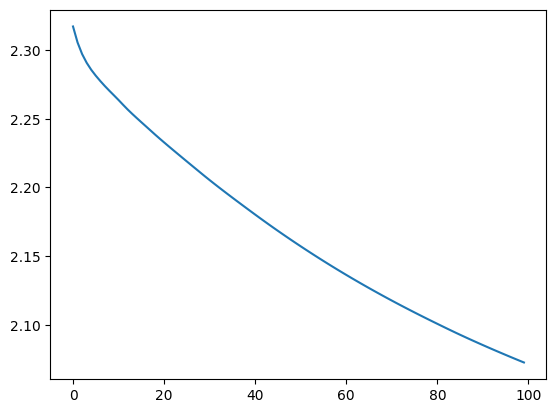

In [179]:
plt.plot(model.history)

In [180]:
y_pred = model(torch.tensor(x_test_flatten / 255, dtype=torch.float32)).detach().softmax(1).argmax(1)
print(classification_report(y_pred.numpy(), y_test.squeeze()))

              precision    recall  f1-score   support

           0       0.53      0.33      0.41      1608
           1       0.18      0.43      0.25       428
           2       0.08      0.31      0.12       242
           3       0.12      0.21      0.16       587
           4       0.21      0.29      0.25       746
           5       0.41      0.23      0.29      1839
           6       0.28      0.34      0.31       840
           7       0.20      0.28      0.23       702
           8       0.47      0.33      0.39      1426
           9       0.50      0.32      0.39      1582

    accuracy                           0.30     10000
   macro avg       0.30      0.31      0.28     10000
weighted avg       0.38      0.30      0.32     10000



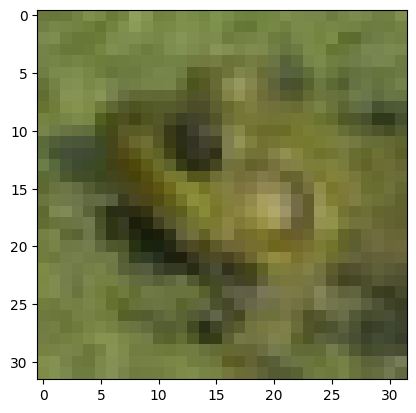

In [182]:
#  предсказание

n = 49
test = x_test_flatten[n]
plt.imshow(x_test[n])

In [183]:
label_id = model(torch.tensor(test / 255, dtype=torch.float32).unsqueeze(0)).detach().softmax(1).argmax(1).item()
id2class[label_id]

'Лягушка'

# Задание 3 CNN image classifier (свертка)

## 3.1 Подготовка модели

In [226]:
class ConvNNModel(nn.Module):
    def __init__(self, in_channels: int, n_classes: int, lr: float = 1e-7) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 6, 5),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 1),

            nn.Conv2d(6, 4, 5),
            nn.GELU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(4, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),

            nn.Linear(144, 128),
            nn.Tanh(),
            nn.Linear(128, n_classes)
        )

        self.history = []

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def fit(self, train_dl: DataLoader, epoch_number: int = 100) -> None:
        fit_history = []
        for epoch in tqdm(range(epoch_number)):
            loss_values = []
            for x_batch, y_batch in train_dl:
                predict = self.model(x_batch)
                loss = self.criterion(predict, y_batch)
                loss_values.append(loss.item())

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

            mean_loss = np.mean(loss_values)
            fit_history.append(mean_loss)
            print(f'\nЭпоха {epoch + 1}, среднее значение функции потерь: {mean_loss}')

        self.history.extend(fit_history)

## 3.2 Обучение модели

In [231]:
def transform(img: np.ndarray) -> np.ndarray:
    new_image = img.transpose(2, 0, 1) / 255
    return new_image

In [241]:
x_train_transform = np.array([
    transform(img) for img in x_train
])

x_test_transform = np.array([
    transform(img) for img in x_test
])

In [235]:
train_ds = TensorDataset(torch.tensor(x_train_transform, dtype=torch.float32), torch.tensor(y_train.squeeze()))
train_dl = DataLoader(train_ds, batch_size=64)

In [237]:
model = ConvNNModel(3, N_CLASSES)
model.fit(train_dl)

  1%|          | 1/100 [00:33<56:00, 33.94s/it]


Эпоха 1, среднее значение функции потерь: 2.30329506385052


  2%|▏         | 2/100 [01:03<51:01, 31.24s/it]


Эпоха 2, среднее значение функции потерь: 2.3032797632924735


  3%|▎         | 3/100 [01:32<49:07, 30.38s/it]


Эпоха 3, среднее значение функции потерь: 2.3032641855956952


  4%|▍         | 4/100 [02:01<47:25, 29.64s/it]


Эпоха 4, среднее значение функции потерь: 2.303248317955095


  5%|▌         | 5/100 [02:29<46:21, 29.28s/it]


Эпоха 5, среднее значение функции потерь: 2.3032322487867702


  6%|▌         | 6/100 [02:59<46:06, 29.43s/it]


Эпоха 6, среднее значение функции потерь: 2.303215868332807


  7%|▋         | 7/100 [03:28<45:08, 29.12s/it]


Эпоха 7, среднее значение функции потерь: 2.303199249155381


  8%|▊         | 8/100 [03:56<44:23, 28.95s/it]


Эпоха 8, среднее значение функции потерь: 2.3031824766217595


  9%|▉         | 9/100 [04:27<44:40, 29.46s/it]


Эпоха 9, среднее значение функции потерь: 2.303165521463165


 10%|█         | 10/100 [04:55<43:41, 29.12s/it]


Эпоха 10, среднее значение функции потерь: 2.3031483748379875


 11%|█         | 11/100 [05:24<43:04, 29.04s/it]


Эпоха 11, среднее значение функции потерь: 2.303131077600562


 12%|█▏        | 12/100 [05:52<42:19, 28.86s/it]


Эпоха 12, среднее значение функции потерь: 2.303113562981491


 13%|█▎        | 13/100 [06:21<41:45, 28.80s/it]


Эпоха 13, среднее значение функции потерь: 2.3030959764100096


 14%|█▍        | 14/100 [06:49<41:08, 28.71s/it]


Эпоха 14, среднее значение функции потерь: 2.3030783453255967


 15%|█▌        | 15/100 [07:18<40:39, 28.70s/it]


Эпоха 15, среднее значение функции потерь: 2.303060682533342


 16%|█▌        | 16/100 [07:48<40:30, 28.93s/it]


Эпоха 16, среднее значение функции потерь: 2.303042921873615


 17%|█▋        | 17/100 [08:16<39:53, 28.84s/it]


Эпоха 17, среднее значение функции потерь: 2.3030250252360274


 18%|█▊        | 18/100 [08:45<39:16, 28.74s/it]


Эпоха 18, среднее значение функции потерь: 2.303007010913566


 19%|█▉        | 19/100 [09:16<39:41, 29.40s/it]


Эпоха 19, среднее значение функции потерь: 2.302988911223838


 20%|██        | 20/100 [09:44<38:47, 29.10s/it]


Эпоха 20, среднее значение функции потерь: 2.3029708228147854


 21%|██        | 21/100 [10:13<38:03, 28.90s/it]


Эпоха 21, среднее значение функции потерь: 2.302952746601056


 22%|██▏       | 22/100 [10:41<37:16, 28.67s/it]


Эпоха 22, среднее значение функции потерь: 2.302934628923226


 23%|██▎       | 23/100 [11:09<36:45, 28.65s/it]


Эпоха 23, среднее значение функции потерь: 2.3029164149023384


 24%|██▍       | 24/100 [11:39<36:44, 29.00s/it]


Эпоха 24, среднее значение функции потерь: 2.3028980862454076


 25%|██▌       | 25/100 [12:08<36:06, 28.89s/it]


Эпоха 25, среднее значение функции потерь: 2.3028797216122716


 26%|██▌       | 26/100 [12:36<35:28, 28.77s/it]


Эпоха 26, среднее значение функции потерь: 2.3028612871609075


 27%|██▋       | 27/100 [13:05<34:56, 28.72s/it]


Эпоха 27, среднее значение функции потерь: 2.302842812769858


 28%|██▊       | 28/100 [13:33<34:23, 28.65s/it]


Эпоха 28, среднее значение функции потерь: 2.302824274048476


 29%|██▉       | 29/100 [14:02<33:54, 28.65s/it]


Эпоха 29, среднее значение функции потерь: 2.3028056981313565


 30%|███       | 30/100 [14:30<33:18, 28.55s/it]


Эпоха 30, среднее значение функции потерь: 2.3027871087993805


 31%|███       | 31/100 [15:00<33:23, 29.04s/it]


Эпоха 31, среднее значение функции потерь: 2.302768435624554


 32%|███▏      | 32/100 [15:29<32:46, 28.92s/it]


Эпоха 32, среднее значение функции потерь: 2.302749688058253


 33%|███▎      | 33/100 [15:58<32:11, 28.83s/it]


Эпоха 33, среднее значение функции потерь: 2.3027308508563227


 34%|███▍      | 34/100 [16:26<31:40, 28.80s/it]


Эпоха 34, среднее значение функции потерь: 2.3027119215796974


 35%|███▌      | 35/100 [16:55<31:08, 28.75s/it]


Эпоха 35, среднее значение функции потерь: 2.3026928578496286


 36%|███▌      | 36/100 [17:24<30:39, 28.75s/it]


Эпоха 36, среднее значение функции потерь: 2.302673659361232


 37%|███▋      | 37/100 [17:52<29:59, 28.56s/it]


Эпоха 37, среднее значение функции потерь: 2.3026542812966935


 38%|███▊      | 38/100 [18:20<29:29, 28.55s/it]


Эпоха 38, среднее значение функции потерь: 2.302634786157047


 39%|███▉      | 39/100 [18:50<29:26, 28.95s/it]


Эпоха 39, среднее значение функции потерь: 2.3026151443686325


 40%|████      | 40/100 [19:19<28:51, 28.86s/it]


Эпоха 40, среднее значение функции потерь: 2.302595342821477


 41%|████      | 41/100 [19:48<28:16, 28.76s/it]


Эпоха 41, среднее значение функции потерь: 2.3025753738935038


 42%|████▏     | 42/100 [20:16<27:40, 28.62s/it]


Эпоха 42, среднее значение функции потерь: 2.3025552049622204


 43%|████▎     | 43/100 [20:44<27:06, 28.53s/it]


Эпоха 43, среднее значение функции потерь: 2.3025348427350565


 44%|████▍     | 44/100 [21:12<26:34, 28.47s/it]


Эпоха 44, среднее значение функции потерь: 2.3025142823338816


 45%|████▌     | 45/100 [21:41<26:07, 28.50s/it]


Эпоха 45, среднее значение функции потерь: 2.302493548454226


 46%|████▌     | 46/100 [22:11<25:57, 28.83s/it]


Эпоха 46, среднее значение функции потерь: 2.3024726072540673


 47%|████▋     | 47/100 [22:39<25:20, 28.69s/it]


Эпоха 47, среднее значение функции потерь: 2.3024514340378746


 48%|████▊     | 48/100 [23:08<24:48, 28.63s/it]


Эпоха 48, среднее значение функции потерь: 2.302429998622221


 49%|████▉     | 49/100 [23:36<24:18, 28.59s/it]


Эпоха 49, среднее значение функции потерь: 2.3024082973485105


 50%|█████     | 50/100 [24:04<23:47, 28.54s/it]


Эпоха 50, среднее значение функции потерь: 2.3023863789980368


 51%|█████     | 51/100 [24:33<23:15, 28.48s/it]


Эпоха 51, среднее значение функции потерь: 2.3023642487538134


 52%|█████▏    | 52/100 [25:01<22:44, 28.43s/it]


Эпоха 52, среднее значение функции потерь: 2.302341831614599


 53%|█████▎    | 53/100 [25:30<22:16, 28.43s/it]


Эпоха 53, среднее значение функции потерь: 2.3023191391659514


 54%|█████▍    | 54/100 [25:59<22:07, 28.86s/it]


Эпоха 54, среднее значение функции потерь: 2.3022961403097946


 55%|█████▌    | 55/100 [26:28<21:31, 28.71s/it]


Эпоха 55, среднее значение функции потерь: 2.3022728941934494


 56%|█████▌    | 56/100 [26:56<20:58, 28.61s/it]


Эпоха 56, среднее значение функции потерь: 2.302249404475512


 57%|█████▋    | 57/100 [27:24<20:25, 28.51s/it]


Эпоха 57, среднее значение функции потерь: 2.302225633655363


 58%|█████▊    | 58/100 [27:58<21:03, 30.09s/it]


Эпоха 58, среднее значение функции потерь: 2.3022015533788736


 59%|█████▉    | 59/100 [28:29<20:47, 30.44s/it]


Эпоха 59, среднее значение функции потерь: 2.3021771279747223


 60%|██████    | 60/100 [28:58<19:54, 29.87s/it]


Эпоха 60, среднее значение функции потерь: 2.3021523440280536


 61%|██████    | 61/100 [29:28<19:23, 29.84s/it]


Эпоха 61, среднее значение функции потерь: 2.302127203368165


 62%|██████▏   | 62/100 [29:56<18:37, 29.41s/it]


Эпоха 62, среднее значение функции потерь: 2.3021017026413433


 63%|██████▎   | 63/100 [30:25<17:59, 29.16s/it]


Эпоха 63, среднее значение функции потерь: 2.3020758506891976


 64%|██████▍   | 64/100 [30:54<17:27, 29.09s/it]


Эпоха 64, среднее значение функции потерь: 2.3020496411091838


 65%|██████▌   | 65/100 [31:22<16:54, 28.99s/it]


Эпоха 65, среднее значение функции потерь: 2.3020230638401586


 66%|██████▌   | 66/100 [31:51<16:25, 28.99s/it]


Эпоха 66, среднее значение функции потерь: 2.3019961265042004


 67%|██████▋   | 67/100 [32:20<15:53, 28.90s/it]


Эпоха 67, среднее значение функции потерь: 2.301968790381156


 68%|██████▊   | 68/100 [32:49<15:25, 28.93s/it]


Эпоха 68, среднее значение функции потерь: 2.3019410591296223


 69%|██████▉   | 69/100 [33:20<15:12, 29.44s/it]


Эпоха 69, среднее значение функции потерь: 2.3019129629330255


 70%|███████   | 70/100 [33:48<14:36, 29.23s/it]


Эпоха 70, среднее значение функции потерь: 2.3018844688639923


 71%|███████   | 71/100 [34:17<14:03, 29.10s/it]


Эпоха 71, среднее значение функции потерь: 2.301855588508079


 72%|███████▏  | 72/100 [34:46<13:34, 29.10s/it]


Эпоха 72, среднее значение функции потерь: 2.3018262919867434


 73%|███████▎  | 73/100 [35:15<13:04, 29.06s/it]


Эпоха 73, среднее значение функции потерь: 2.301796549116559


 74%|███████▍  | 74/100 [35:44<12:32, 28.94s/it]


Эпоха 74, среднее значение функции потерь: 2.301766328189684


 75%|███████▌  | 75/100 [36:13<12:06, 29.04s/it]


Эпоха 75, среднее значение функции потерь: 2.301735663962791


 76%|███████▌  | 76/100 [36:56<13:14, 33.09s/it]


Эпоха 76, среднее значение функции потерь: 2.3017045969853314


 77%|███████▋  | 77/100 [37:24<12:10, 31.75s/it]


Эпоха 77, среднее значение функции потерь: 2.3016730912811005


 78%|███████▊  | 78/100 [37:53<11:17, 30.78s/it]


Эпоха 78, среднее значение функции потерь: 2.3016410831295318


 79%|███████▉  | 79/100 [38:22<10:33, 30.17s/it]


Эпоха 79, среднее значение функции потерь: 2.3016086115556607


 80%|████████  | 80/100 [38:51<09:57, 29.88s/it]


Эпоха 80, среднее значение функции потерь: 2.301575656742086


 81%|████████  | 81/100 [39:19<09:18, 29.42s/it]


Эпоха 81, среднее значение функции потерь: 2.3015422272255353


 82%|████████▏ | 82/100 [39:53<09:15, 30.85s/it]


Эпоха 82, среднее значение функции потерь: 2.3015082909932834


 83%|████████▎ | 83/100 [40:23<08:39, 30.57s/it]


Эпоха 83, среднее значение функции потерь: 2.3014738642041337


 84%|████████▍ | 84/100 [40:52<07:59, 29.95s/it]


Эпоха 84, среднее значение функции потерь: 2.301438964541306


 85%|████████▌ | 85/100 [41:21<07:25, 29.69s/it]


Эпоха 85, среднее значение функции потерь: 2.3014035837729567


 86%|████████▌ | 86/100 [41:50<06:51, 29.38s/it]


Эпоха 86, среднее значение функции потерь: 2.3013676709836095


 87%|████████▋ | 87/100 [42:18<06:19, 29.22s/it]


Эпоха 87, среднее значение функции потерь: 2.3013312581859893


 88%|████████▊ | 88/100 [42:47<05:49, 29.12s/it]


Эпоха 88, среднее значение функции потерь: 2.301294380441651


 89%|████████▉ | 89/100 [43:17<05:20, 29.17s/it]


Эпоха 89, среднее значение функции потерь: 2.3012569581761078


 90%|█████████ | 90/100 [43:45<04:50, 29.05s/it]


Эпоха 90, среднее значение функции потерь: 2.3012189737061406


 91%|█████████ | 91/100 [44:15<04:24, 29.38s/it]


Эпоха 91, среднее значение функции потерь: 2.3011804895327828


 92%|█████████▏| 92/100 [44:45<03:54, 29.28s/it]


Эпоха 92, среднее значение функции потерь: 2.301141442850118


 93%|█████████▎| 93/100 [45:13<03:24, 29.15s/it]


Эпоха 93, среднее значение функции потерь: 2.301101822072588


 94%|█████████▍| 94/100 [45:42<02:54, 29.12s/it]


Эпоха 94, среднее значение функции потерь: 2.30106161317557


 95%|█████████▌| 95/100 [46:11<02:25, 29.04s/it]


Эпоха 95, среднее значение функции потерь: 2.301020828049506


 96%|█████████▌| 96/100 [46:40<01:56, 29.05s/it]


Эпоха 96, среднее значение функции потерь: 2.3009794703529924


 97%|█████████▋| 97/100 [47:10<01:27, 29.11s/it]


Эпоха 97, среднее значение функции потерь: 2.3009375349030163


 98%|█████████▊| 98/100 [47:39<00:58, 29.22s/it]


Эпоха 98, среднее значение функции потерь: 2.300895036333967


 99%|█████████▉| 99/100 [48:09<00:29, 29.32s/it]


Эпоха 99, среднее значение функции потерь: 2.3008519706823636


100%|██████████| 100/100 [48:37<00:00, 29.18s/it]


Эпоха 100, среднее значение функции потерь: 2.3008083480093484


In [242]:
y_pred = model(torch.tensor(x_test_transform, dtype=torch.float32)).detach().softmax(1).argmax(1)
print(classification_report(y_pred.numpy(), y_test.squeeze()))

              precision    recall  f1-score   support

           0       0.37      0.16      0.22      2258
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.18      0.14      0.16      1301
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         0
           9       0.70      0.11      0.19      6437

    accuracy                           0.12     10000
   macro avg       0.12      0.04      0.06     10000
weighted avg       0.56      0.12      0.19     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


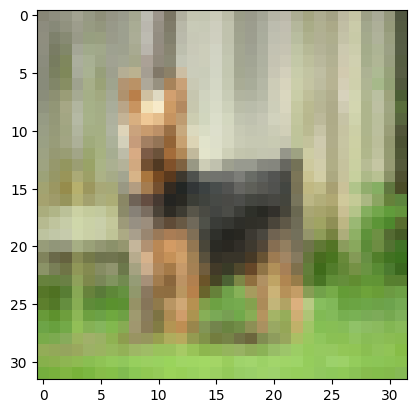

In [244]:
#  предсказание

n = 24
test = x_test_transform[n]
plt.imshow(x_test[n])

In [246]:
label_id = model(torch.tensor(test, dtype=torch.float32).unsqueeze(0)).detach().softmax(1).argmax(1).item()
id2class[label_id]

'Грузовик'